 Data Loaded: 1500 points
[Run 1] NEW BEST FOUND --> L1 = 37865.094332
[Run 2] NEW BEST FOUND --> L1 = 37865.093921
[Run 3] no improvement.
[Run 4] no improvement.
[Run 5] NEW BEST FOUND --> L1 = 37865.093861
[Run 6] no improvement.
[Run 7] no improvement.
[Run 8] NEW BEST FOUND --> L1 = 37865.093846
[Run 9] no improvement.
[Run 10] no improvement.
[Run 11] no improvement.
[Run 12] no improvement.

================ FINAL ESTIMATED PARAMETERS ================
Theta (deg) = 28.118421
M           = 0.021389
X           = 54.900228

Total L1 Error           = 37865.093846
Average L1 error/point   = 25.243396
Runtime (seconds)        = 0.30



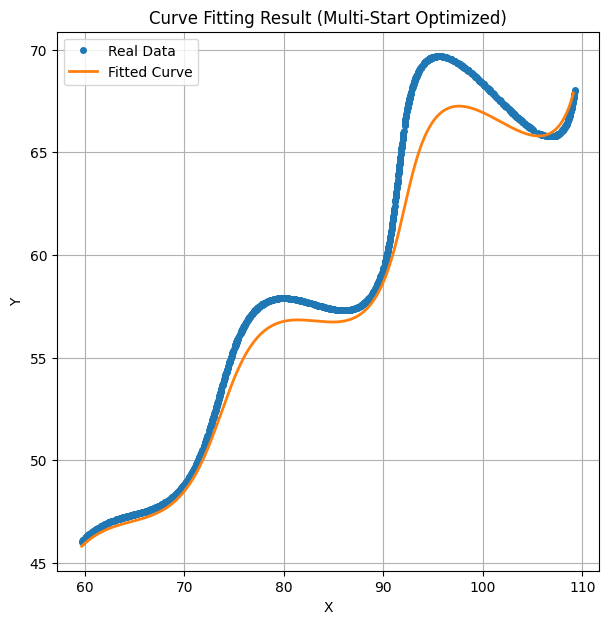

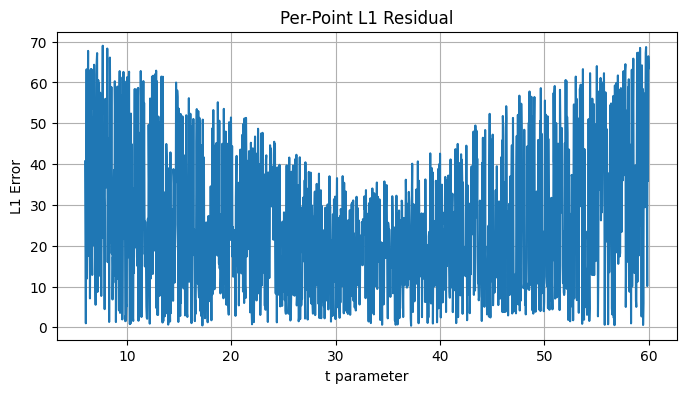


 Residual diagnostics plotted.


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time

# -------------------------------------------------------------------
# 0. CONFIGURATION
# -------------------------------------------------------------------
np.random.seed(42)             # reproducibility
N_RESTARTS = 12                # multi-start search
VERBOSE = True

# -------------------------------------------------------------------
# 1. LOAD DATA
# -------------------------------------------------------------------
df = pd.read_csv("xy_data.csv")

x_real = df.iloc[:,0].values
y_real = df.iloc[:,1].values
t_data = np.linspace(6, 60, len(df))

print(f" Data Loaded: {len(df)} points")


# -------------------------------------------------------------------
# 2. PARAMETRIC CURVE MODEL
# -------------------------------------------------------------------
def parametric_curve(t, theta, M, X):
    th = np.deg2rad(theta)
    exp_term = np.exp(M * np.abs(t)) * np.sin(0.3 * t)

    x = t*np.cos(th) - exp_term*np.sin(th) + X
    y = 42 + t*np.sin(th) + exp_term*np.cos(th)

    return x, y


# -------------------------------------------------------------------
# 3. L1 OBJECTIVE FUNCTION
# -------------------------------------------------------------------
def objective(params):
    theta, M, X = params
    x_pred, y_pred = parametric_curve(t_data, theta, M, X)
    return np.sum(np.abs(x_real - x_pred) + np.abs(y_real - y_pred))


# -------------------------------------------------------------------
# 4. PARAMETER BOUNDS
# -------------------------------------------------------------------
bounds = [(0, 50), (-0.05, 0.05), (0, 100)]


# -------------------------------------------------------------------
# 5. MULTI-START OPTIMIZATION
# -------------------------------------------------------------------
best_params = None
best_error = np.inf
start_time = time.time()

for run in range(N_RESTARTS):
    initial_guess = [
        np.random.uniform(0, 50),
        np.random.uniform(-0.05, 0.05),
        np.random.uniform(0, 100)
    ]

    result = minimize(objective, initial_guess,
                      bounds=bounds, method='L-BFGS-B',
                      options={'maxiter': 6000})

    if result.fun < best_error:
        best_error = result.fun
        best_params = result.x
        if VERBOSE:
            print(f"[Run {run+1}] NEW BEST FOUND --> L1 = {best_error:.6f}")
    else:
        print(f"[Run {run+1}] no improvement.")


# -------------------------------------------------------------------
# 6. FINAL RESULTS
# -------------------------------------------------------------------
theta_est, M_est, X_est = best_params
runtime = time.time() - start_time

print("\n================ FINAL ESTIMATED PARAMETERS ================")
print(f"Theta (deg) = {theta_est:.6f}")
print(f"M           = {M_est:.6f}")
print(f"X           = {X_est:.6f}")
print(f"\nTotal L1 Error           = {best_error:.6f}")
print(f"Average L1 error/point   = {best_error/len(df):.6f}")
print(f"Runtime (seconds)        = {runtime:.2f}")
print("=============================================================\n")


# -------------------------------------------------------------------
# 7. PLOT COMPARISON
# -------------------------------------------------------------------
x_fit, y_fit = parametric_curve(t_data, theta_est, M_est, X_est)

plt.figure(figsize=(7,7))
plt.plot(x_real, y_real, 'o', label="Real Data", markersize=4)
plt.plot(x_fit, y_fit, '-', label="Fitted Curve", linewidth=2)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Curve Fitting Result (Multi-Start Optimized)")
plt.legend()
plt.grid(True)
plt.show()


# -------------------------------------------------------------------
# 8. RESIDUAL DIAGNOSTICS
# -------------------------------------------------------------------
residuals = np.abs(x_real - x_fit) + np.abs(y_real - y_fit)

plt.figure(figsize=(8,4))
plt.plot(t_data, residuals)
plt.title("Per-Point L1 Residual")
plt.xlabel("t parameter")
plt.ylabel("L1 Error")
plt.grid(True)
plt.show()

print("\n Residual diagnostics plotted.")
